## Применение алгоритма Гровера для решения судоку 3nx3n


In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import Aer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.visualization import plot_histogram 

Нумеровать элементы судоку будем аналогично матрице 'a'. Раскладывать будем числа 0, 1, 2.

In [2]:
a = np.arange(9)
a.shape=(3,3)
print(a)

[[0 1 2]
 [3 4 5]
 [6 7 8]]


In [3]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # |s> -> |00..0> (H-вентиль)
    for qubit in range(nqubits):
        qc.h(qubit)
    # |00..0> -> |11..1> (X-вентиль)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Управляемый Z-вентиль
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # управляемый вентиль Тоффоли
    qc.h(nqubits-1)
    # |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # Мы вернем диффузер как вентиль
    U_s = qc.to_gate()
    U_s.name = "U_s"
    return U_s

Лист исключений clause_list - позиции, цифры на которых не должны совпадать

In [4]:
clause_list = np.array([[0,1,2],
               [3,4,5],
               [6,7,8],
               [0,3,6],
               [1,4,7],
               [2,5,8]])

Вентиль XOR: в функции написано A xor B xor C.

Управляемый вентиль cX действует операцией "НЕ" на 2 кубит, если на 1 кубите значение "1"

Смысл в том, что если мы ставим управляющие биты на позиции, которые не должны быть равны, то 
Если они равны, то с битом ничего не произойдет; Если не равны, то бит инвертируется.

In [5]:
def XOR(qc, a, b, c, output, garbage):
    qc.cx(a, garbage)
    qc.cx(b, garbage)
    qc.cx(garbage,output)
    qc.cx(c, output)
 
    #Возвращаем output0 в изначальное состояние
    qc.cx(a, garbage)
    qc.cx(b, garbage)

# Основная часть программы

In [6]:
# Создаем кубиты var_qubits, store_qubit, clause_qubits,output_qubit и классические биты cbits 
var_qubits = QuantumRegister(9, name='input')  # кубиты, на которые подаются случайные значения
store_qubit = QuantumRegister(1, name='garbage') # кубит для проведения операций над другими кубитами
clause_qubits = QuantumRegister(6, name='store')  # кубиты для временного хранения значений
output_qubit = QuantumRegister(1, name='output') # выходной кубит, в котором лежат значения, удовлетворяющие требованиям
cbits = ClassicalRegister(9, name='cbits') # классические биты, в которые положим результаты измерения кубитов
qc = QuantumCircuit(var_qubits,store_qubit, clause_qubits, output_qubit, cbits) # Создаем цепь

def sudoku_oracle(qc, clause_list, clause_qubits, store_qubit):
    # Проверяем удовлетворяют ли значения на var_qubits нужным требованиям из clause_list
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause[2], clause_qubits[i], store_qubit)
        i += 1
    
    # Меняем значение выходного кубита, если все требования учтены
    qc.mct(clause_qubits, output_qubit) # множественный cX 

    # Возвращаем все clause_qubits в изначальное состояние
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause[2], clause_qubits[i], store_qubit)
        i += 1
        
# Инициализируем 'output' в состояние |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Инициализируем кубиты в состояние |s>
qc.h(var_qubits)
qc.barrier()

## Первая итерация
sudoku_oracle(qc, clause_list, clause_qubits, store_qubit)
qc.barrier() 
qc.append(diffuser(9), [0,1,2,3,4,5,6,7,8])

## Вторая итерация
sudoku_oracle(qc, clause_list, clause_qubits, store_qubit)
qc.barrier()
qc.append(diffuser(9), [0,1,2,3,4,5,6,7,8])

# Измеряем var_qubits и записываем значение в классические биты
qc.measure(var_qubits, cbits)

qc.draw(fold=-1)

┌───┐               ░                                                                                                                                                                                                                                                                                                                                                                          ░ ┌──────┐                                                                                                                                                                                                                                                                                                                                                                         ░ ┌──────┐┌─┐                        
input_0: ─────────────┤ H ├───────────────░───■───────────────────■─────────────────────────────────────────────────────────────────────■───────────────────■─────────────────────────────────────────────────────────────────────■───────────────────■─────────────────────────────────────────────────────────────────────■───────────────────■────────────────────────────────────────────────────────────────────░─┤0     ├──■───────────────────■─────────────────────────────────────────────────────────────────────■───────────────────■─────────────────────────────────────────────────────────────────────■───────────────────■─────────────────────────────────────────────────────────────────────■───────────────────■────────────────────────────────────────────────────────────────────░─┤0     ├┤M├────────────────────────
                      ├───┤               ░   │                   │                                                                     │                   │                                                                     │                   │                                                                     │                   │                                                                    ░ │      │  │                   │                                                                     │                   │                                                                     │                   │                                                                     │                   │                                                                    ░ │      │└╥┘┌─┐                     
input_1: ─────────────┤ H ├───────────────░───┼────■──────────────┼────■────────────────────────────────────────────────────────────────┼───────────────────┼─────────■───────────────────■───────────────────────────────────────┼────■──────────────┼────■────────────────────────────────────────────────────────────────┼───────────────────┼─────────■───────────────────■──────────────────────────────────────░─┤1     ├──┼────■──────────────┼────■────────────────────────────────────────────────────────────────┼───────────────────┼─────────■───────────────────■───────────────────────────────────────┼────■──────────────┼────■────────────────────────────────────────────────────────────────┼───────────────────┼─────────■───────────────────■──────────────────────────────────────░─┤1     ├─╫─┤M├─────────────────────
                      ├───┤               ░   │    │              │    │                                                                │                   │         │                   │                                       │    │              │    │                                                                │                   │         │                   │                                      ░ │      │  │    │              │    │                                                                │                   │         │                   │                                       │    │              │    │                                                                │                   │         │                   │                            

In [17]:
%%time
# Включаем симулятор квантового компьютера
aer_simulator = Aer.get_backend('aer_simulator')
# Преобразуем нашу цепь в читабельный формат для квантового компьютера, оптимизируем вентили и запускаем 500 раз
result = execute(qc, aer_simulator, shots=500, memory=True).result()
counts = result.get_counts(qc)

Wall time: 25.8 s


Время одного решения судоку ~0.05с, но из-за того, что квантовый компьютер мыслит вероятностями приходится делать много запусков.
Также значительное время уходит на преобразование цепи в читаемый для квантового компьютера вид (внутри execute)

На этом этапе можно заметить, что на гистограмме присутствуют строки формата 'xxx111xxx', что означает что в будущем мы поставим в 1 строку какое-то из чисел '01' или '10' 2 раза, что противоречит правилам. Эта ошибка возникает из-за того что A xor B xor C выдает True при A = True, B = True, C = True. Это можно исправить при помощи замены функции XOR на другую логическую цепочку или исправить далее в коде вручную, как и было сделано.

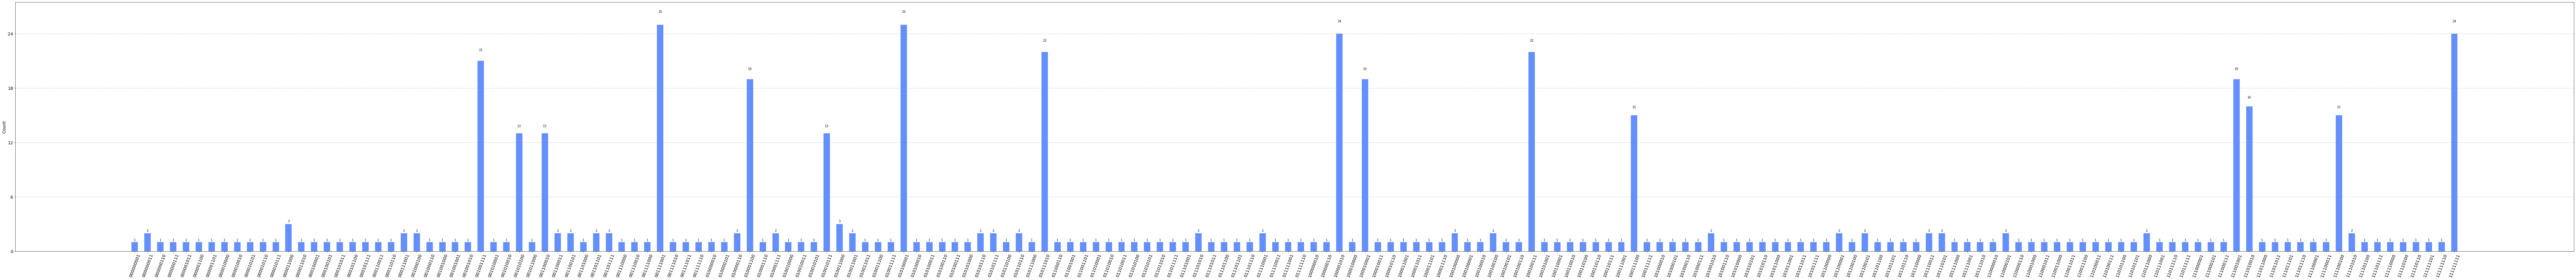

In [18]:
plot_histogram(counts, figsize=(150,15))

In [27]:
# выкидываем маловероятные значения и значения с '111'
keys = []
for key in counts:
    if counts[key] < 7 or '111' in str(key): 
        keys.append(key)

for key in keys:
    counts.pop(key)

keys=[]
for key in counts:
    keys.append([*key])

# Закидываем оставшиеся значения в массив pre_answer и 'смешиваем' их. После этого выкидываем все последовательности, 
# в которых появилась цифра 3, так как она не предусмотрена нашими правилами игры.
i=0
letter =''
letter_int=''
pre_answer=[]
answer=[]
for part1 in keys: 
    for part2 in keys:
        for i in range(len(part2)):
            pre_answer.append(part1[i])
            pre_answer.append(part2[i])

for symbol in pre_answer:
    letter += symbol
    i+=1
    if i % 2 == 0 and i != 0:
        letter_int += str(int(letter, 2))
        letter = ''
    elif i == 18:
        if not '3' in letter_int:
            answer.append(letter_int)
        i = 0
        letter = ''
        letter_int =''
    
    
print(answer)
print(len(answer))

['012120201', '102021210', '120012201', '021102210', '210021102', '201120012', '021210102', '120201012', '201012120', '210102021', '012201120', '102210021']
12


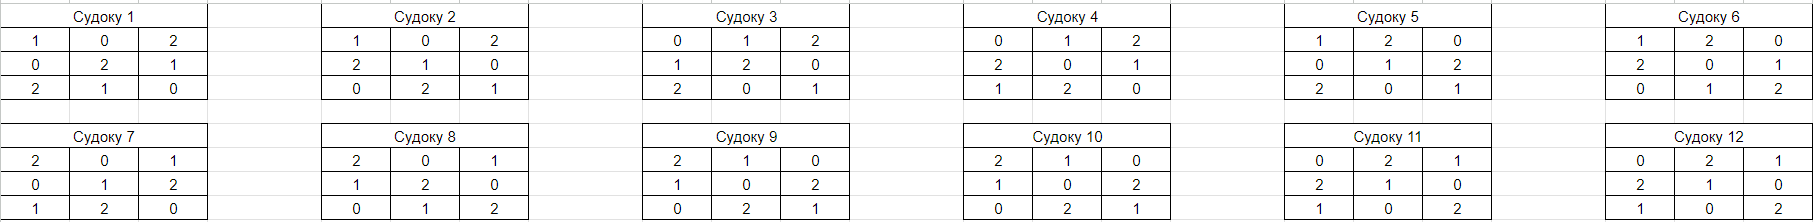